In [1]:
import torch
import torchvision.models as models
from torchvision import datasets
from glob import glob
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from tqdm import tqdm
from torch.optim import lr_scheduler
device = 'cuda' if torch.cuda.is_available() else 'cpu'

(224, 224, 3)


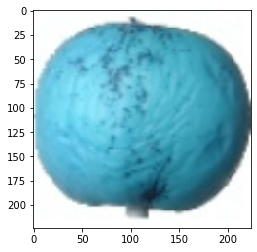

In [2]:
#Dar resize em todas as imagens com esse tamanho
IMAGE_SIZE = [224,224]

#Configurações de treino
epochs = 5
batch_size = 100

#Pegando os diretórios do dataset
train_path = '../VGG/fruits-360-small/Training'
valid_path = '../VGG/fruits-360-small/Test'

#Pegando o nome de todas as imagens
#O jp*g é porque o JPEG pode ter o formato .jpg ou .jpeg
image_files = glob(train_path + '/*/*.jp*g')
#print(image_files[0])
valid_image_files = glob(valid_path + '/*/*.jp*g')

#Pegar o nome das pastas com as classes
folders = glob(train_path + '/*')
#print(IMAGE_SIZE[0])

#Vamos visualizar uma imagem aleatória no pyplot

ny = np.random.choice(image_files)
print(cv2.imread(ny).shape)
plt.imshow(cv2.imread(ny))
plt.show()

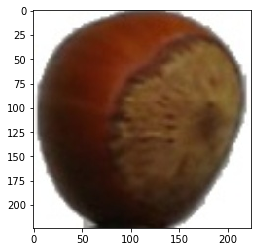

In [4]:
batch = 1
import torchvision.transforms as transforms
#Criando uma série de transformações nas imagens, a fim de melhorar a acuracidade do dataset
data_transform = transforms.Compose([
        
        transforms.Resize(224),
        #transforms.RandomRotation(20),
        #transforms.RandomHorizontalFlip(),
        #transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
    ])

train_Data = datasets.ImageFolder(train_path,transform=data_transform)
valid_Data = datasets.ImageFolder(valid_path, transform=data_transform)


#Criando um loader para criar o dataset para treino e teste
train_loader = torch.utils.data.DataLoader(train_Data, batch_size=batch, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_Data, batch_size=batch, shuffle=True)


#Pegando uma imagem e plotando
for data,target in train_loader:
    #print(train_loader.shape)
    plt.imshow(data[0].permute(1,2,0))
    plt.show()
    break


In [4]:
#Pegando o pre-trained model VGG e criando uma nova layer em seguida dela
model = models.resnet50(pretrained=True)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 120)
model.to(device)
model.tr
summary(model, input_size=(3, IMAGE_SIZE[0], IMAGE_SIZE[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [5]:
#Criando um optimizer para apenas a ÚLTIMA layer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

#Criando a loss function
loss_function = nn.CrossEntropyLoss()
cont = 0


exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [9]:
import time
import os

val_cont = 0
train_loss = 0
train_acc = 0

val_loss = 0.0
val_acc = 0.0
l = 0

MODEL_NAME = f"model-{int(time.time())}"
EPOCHS = 1
best = 0.0
with open("model.log", "a") as f:
    for epoch in range(EPOCHS):
        i = 0
        exp_lr_scheduler.step()
        for data,target in tqdm(train_loader):
            data, target = data.to(device), target.to(device)
            
            model.zero_grad()
            output = model(data)
            loss = loss_function(output,target)
            _, preds = torch.max(output, 1)
          
            loss.backward()
            optimizer.step()
 
            #Estatística da rede neural
            train_loss += loss.item() * data.size(0)
            train_acc += torch.sum(preds == target.data)
            i += 1

            if i % 10 ==0:

                with torch.no_grad():
                    for val_data, val_target in valid_loader:
                        val_data, val_target = val_data.to(device), val_target.to(device)

                        model.zero_grad()
                        val_out = model(val_data)
                        _, val_preds = torch.max(val_out, 1)

                        val_loss += loss_function(val_out,val_target).item() * val_data.size(0)
                        val_acc += torch.sum(val_preds == val_target.data)

                        l += len(val_target)
                        break
                v_loss = val_loss / l
                v_acc = val_acc / l
                #print(v_acc)
                if v_acc>best:
                    best = v_acc
                    torch.save(model, os.path.join(os.getcwd(),'model_Resnet.pth'))
                f.write(f"{MODEL_NAME}, {round(time.time(),3)}, {round(float(v_acc),2)}, {round(float(v_loss),2)}\n")




100%|██████████| 770/770 [14:44<00:00,  1.15s/it]


In [ ]:
data_transform = transforms.Compose([
        
        transforms.Resize(224),
        #transforms.RandomRotation(20),
        #transforms.RandomHorizontalFlip(),
        #transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
    ])
predict_data = datasets.ImageFolder(valid_path, transform=data_transform)
predict_loader = torch.utils.data.DataLoader(valid_Data, batch_size=1, shuffle=True)


In [15]:
model = torch.load(os.path.join(os.getcwd(), 'model_VGG.pth'))

model.to(device)
model.eval()
import time
for data,target in train_loader:
    data = data / 255.0
    print(data.shape)
    data = torch.tensor(data, dtype=torch.float32).to(device)
    print(len(data))
    with torch.no_grad():
        atual = time.time_ns()
        output = model(data)
        print(time.time_ns() - atual)
    
    break

torch.Size([1, 3, 224, 224])
1
45876200
